In [1]:
!nvidia-smi

Thu Oct 26 15:19:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:3B:00.0 Off |                  Off |
| 30%   30C    P8    22W / 300W |   1184MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:5E:00.0 Off |                  Off |
| 30%   

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(1)

GPU device: NVIDIA RTX A6000


In [3]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 4 GPUs!


In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

set_seeds(42)

import pickle
file_path = "/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/split_0/features_all.pkl"
# Load data_list from the saved file
with open(file_path, 'rb') as file:
    features_all = pickle.load(file)

In [6]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from typing import List, Dict

class CustomImageDataset(Dataset):
    """
    Custom dataset for loading image data from a directory.

    Args:
        root_dir (str): Root directory containing class subdirectories.
        transform (callable, optional): A function/transform to apply to the image.
    """

    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(root_dir)
        self.samples = self._load_samples()
        self.class_ratios = self._calculate_class_ratios()

    def _find_classes(self, directory: str) -> (List[str], Dict[str, int]):
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _load_samples(self):
        samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root_dir, target_class)
            class_idx = self.class_to_idx[target_class]
            for root, _, fnames in os.walk(class_dir):
                for fname in fnames:
                    path = os.path.join(root, fname)
                    samples.append((path, class_idx))
        return samples

    def _calculate_class_ratios(self):
        class_counts = [0] * len(self.classes)
        for _, class_idx in self.samples:
            class_counts[class_idx] += 1

        total_samples = len(self.samples)
        class_ratios = [count / total_samples for count in class_counts]

        return class_ratios

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, target = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, target, img_path

In [8]:
import torch
import timm
from pathlib import Path
from PIL import Image
# Load the pretrained ViT model
model = timm.create_model(
    'vit_huge_patch14_224.orig_in21k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()
model = model.to(device)
# Create data transforms
data_config = timm.data.resolve_model_data_config(model)
data_transforms = timm.data.create_transform(**data_config, is_training=False)

In [9]:
# Create a CustomImageDataset instance
dataset = CustomImageDataset(root_dir='/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train', 
                             transform=data_transforms
                             )

# Create a DataLoader with custom collate_fn
dataloader = DataLoader(dataset, 
                        batch_size=1024, 
                        shuffle=True,
                        num_workers=16, 
                        #collate_fn=custom_collate,
                        drop_last=False,
                        )

# Calculate the total number of batches
total_batches = len(dataloader)
total_batches

254

In [9]:
from tqdm import tqdm
import pickle

# Initialize a list to accumulate features
all_features = []
all_gt_labels = []
img_paths_batchwise = []

with torch.no_grad():
    for batch in tqdm(dataloader, total=len(dataloader)):
        setup_ccname()
        images, targets, img_paths = batch
        images = images.to(device)
        features = model(images)
        features = features.to('cpu')
        all_features.append(features)
        all_gt_labels.append(targets)
        img_paths_batchwise.append(img_paths)

# Collect features
all_features = torch.cat(all_features, dim=0)
all_gt_labels = torch.cat(all_gt_labels, dim=0)
# all_img_paths = torch.cat(img_paths_batchwise, dim=0)

# Save features_all as a list in pickle format
with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_features.pkl', 'wb') as file:
    pickle.dump(all_features, file)

with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_labels.pkl', 'wb') as file:
    pickle.dump(all_gt_labels, file)

#with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_imagepaths.pkl', 'wb') as file:
#    pickle.dump(all_img_paths, file)


100%|██████████| 254/254 [1:30:32<00:00, 21.39s/it]


TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [10]:
all_img_paths = img_paths_batchwise
with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_imagepaths.pkl', 'wb') as file:
    pickle.dump(all_img_paths, file)

In [11]:
len(all_features)

259865

In [12]:
# Save features_all as a list in pickle format
with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_features.pkl', 'wb') as file:
    pickle.dump(all_features, file)

In [13]:
len(all_gt_labels)

259865

In [14]:
with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_labels.pkl', 'wb') as file:
    pickle.dump(all_gt_labels, file)

In [12]:
import pickle
# Save features_all as a list in pickle format
with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_features.pkl', 'rb') as file:
    all_features_loaded = pickle.load(file)

with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_labels.pkl', 'rb') as file:
    all_gt_labels_loaded = pickle.load(file)

with open('/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_imagepaths.pkl', 'rb') as file:
    all_img_paths_loaded = pickle.load(file)

In [14]:
all_features_loaded.shape

torch.Size([259865, 1280])

In [15]:
all_gt_labels_loaded.dtype

torch.int64

In [16]:
all_gt_labels_loaded.shape

torch.Size([259865])

In [19]:
all_img_paths_loaded.__len__()

254

In [20]:
first_path = all_img_paths_loaded[0][0]
first_path

'/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train/fastening_seat_belt/12_vp12_run1_2018-05-24-15-44-28.kinect_color_frames_3952_3998_ann_11_chunk_0/img_003962.png'

In [21]:
first_gt_label = all_gt_labels_loaded[0]
first_gt_label

tensor(8)

In [23]:
classes_in_dataset = dataset.classes
print(f"The class with 8th index in the DAA Image split_0 train dataset are:{classes_in_dataset[8]}")

The class with 8th index in the DAA Image split_0 train dataset are:fastening_seat_belt


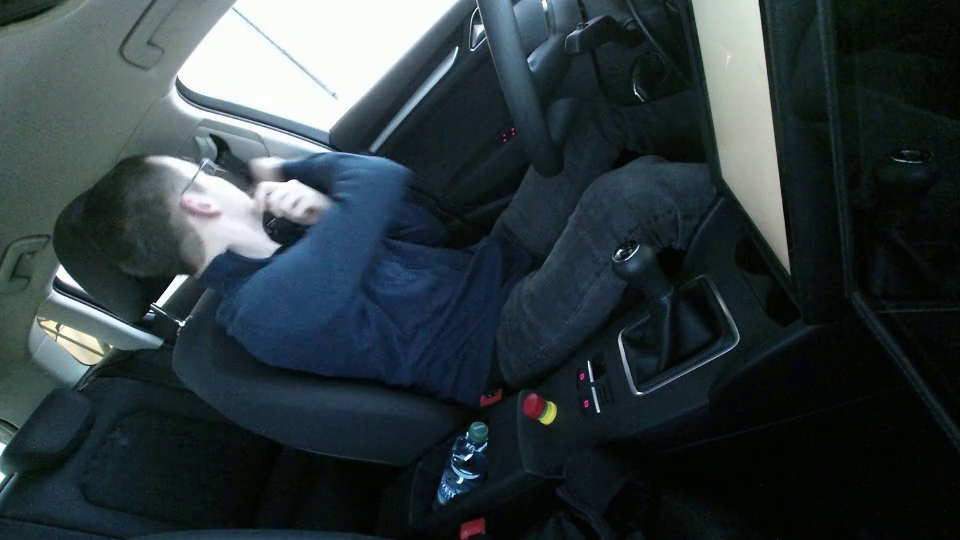

In [27]:
#import torchvision
# image_tensor =  torchvision.io.read_image(first_path)

from PIL import Image

img = Image.open(first_path)
img
